# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ __(5 pts)__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ __(bonus: 5 pts each)__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params), show graphs for different params
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. 
* 20-neuron network is probably not enough, feel free to experiment.

In [1]:
import gym
from joblib import Parallel, delayed
import time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
%matplotlib inline

In [2]:
mountain_car_threshold = -150
lunar_landen_threshold = 50

### Основные функции
---

#### Инициализация окружения

In [3]:
def init_env(env_name):
    env = gym.make(env_name).env
    env.reset()
    n_actions = env.action_space.n
    return env, n_actions

#### Генерация сессии игры

In [4]:
def generate_session(t_max=5000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])
        
        a = np.random.choice(np.arange(n_actions), p=probs[0])
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)

        total_reward += r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

#### Создание агента нейросети

In [5]:
def get_agent(layers_sizes):
    agent = MLPClassifier(hidden_layer_sizes=layers_sizes,
                        activation='tanh',
                        warm_start=True, #keep progress between .fit(...) calls
                        max_iter=1 #make only 1 iteration on each .fit(...)
                        )
    agent.fit([env.reset()]*n_actions,range(n_actions))
    return agent

#### Графическое отображение прогресса

In [6]:
def show_progress(rewards_batch,log, reward_range=[-5000,+5000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    #print(rewards_batch)
    reward_range=[-1010,+10]
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


#### Отсечение лучших игр

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch,percentile)

    elite_states = []

    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(states_batch[rewards_batch >= reward_threshold])
    else:
        elite_states = np.vstack(states_batch[rewards_batch >= reward_threshold])
    elite_actions = np.hstack(actions_batch[rewards_batch >= reward_threshold])

    return elite_states,elite_actions

### Обучение
---

mean reward = -144.730, threshold=-138.000


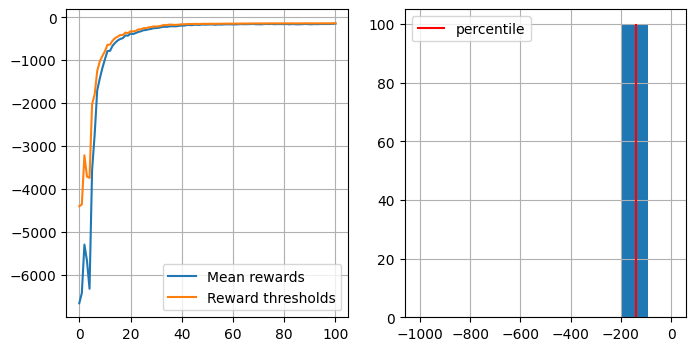

Time: 1411.6780459880829
Win!
Time: 1411.6782302856445


In [18]:
env, n_actions = init_env('MountainCar-v0')

n_sessions = 100
percentile = 70
log = []
startTime = time.time()

layers_sizes = (40, 40)

agent = get_agent(layers_sizes)

for i in range(10000):
    #generate new sessions
    sessions = [generate_session(t_max=10000) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(lambda x: np.array(x, dtype=np.ndarray),zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if (rewards_batch.mean() > mountain_car_threshold):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = 60.278, threshold=34.901


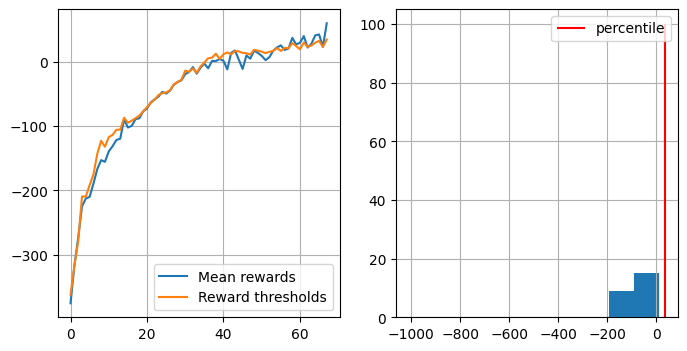

Time: 1322.8684258460999
Win!
Time: 1322.8686287403107


In [55]:
env, n_actions = init_env('LunarLander-v2')

n_sessions = 100
percentile = 50
startTime = time.time()

layers_sizes = (40, 40)

agent = get_agent(layers_sizes)

log = []

for i in range(10000):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(lambda x: np.array(x, dtype=np.ndarray),zip(*sessions))
    print(states_batch, actions_batch, rewards_batch, sep='\n')
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if (rewards_batch.mean() > lunar_landen_threshold):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

### Using JOBLIB
---

mean reward = -148.200, threshold=-146.000


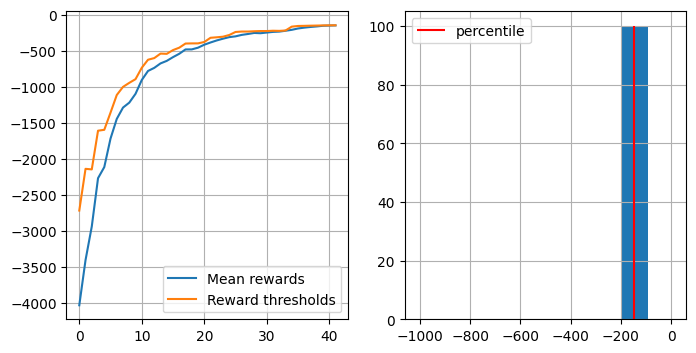

Time: 837.2401239871979
Win!
Time: 837.2406046390533


In [17]:
env, n_actions = init_env('MountainCar-v0')

n_sessions = 100
percentile = 70
log = []
startTime = time.time()

layers_sizes = (40, 40)

agent = get_agent(layers_sizes)

for i in range(10000):
    #generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(t_max=10000) for _ in range(n_sessions))
    
    states_batch,actions_batch,rewards_batch = map(lambda x: np.array(x, dtype=np.ndarray),zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if (rewards_batch.mean() > mountain_car_threshold):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = 57.101, threshold=35.043


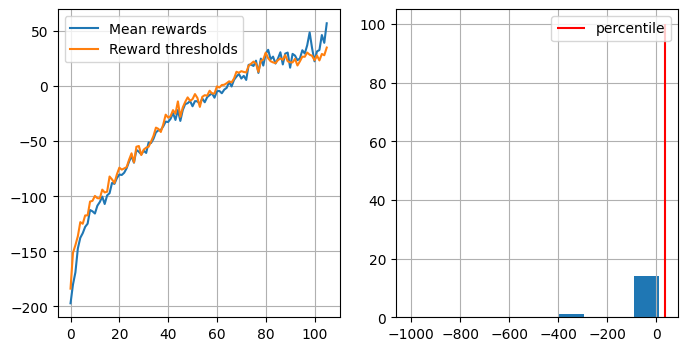

Time: 1054.3211936950684
Win!
Time: 1054.3213741779327


In [26]:
env, n_actions = init_env('LunarLander-v2')

n_sessions = 100
percentile = 50
startTime = time.time()

layers_sizes = (40, 40)

agent = get_agent(layers_sizes)

log = []

for i in range(10000):
    #generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = map(lambda x: np.array(x, dtype=np.ndarray),zip(*sessions))
    print(states_batch, actions_batch, rewards_batch, sep='\n')
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    print("Time:", time.time() - startTime)
    
    if (rewards_batch.mean() > lunar_landen_threshold):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

### Переиспользование уже подсчитанных значений (на примере `MountainCar`)
---

mean reward = -149.590, threshold=-147.000


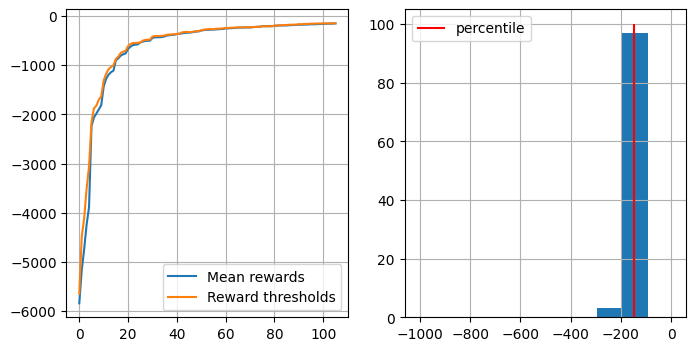

Time: 632.701719045639
Win!
Time: 632.7020428180695


In [14]:
env, n_actions = init_env('MountainCar-v0')

n_sessions = 100
percentile = 50
log = []
startTime = time.time()

layers_sizes = (40, 40)

agent = get_agent(layers_sizes)

prev_sessions = []
group_size = 5

for i in range(10000):
    #generate new sessions
    if i % group_size == 0:
        prev_sessions = []
    prev_sessions += Parallel(n_jobs=-1)(delayed(generate_session)(t_max=10000) for _ in range(n_sessions))
    sessions = prev_sessions

    states_batch,actions_batch,rewards_batch = map(lambda x: np.array(x, dtype=np.ndarray),zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

    print("Time:", time.time() - startTime)

    if (rewards_batch.mean() > mountain_car_threshold):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")